# Comprehensive Loan Data Exploration & Analysis

This notebook provides comprehensive data exploration including:
- Data loading and initial exploration from model.ipynb
- **Loan age calculation** from disbursement date
- **Delinquency status tracking** over time
- **Historical roll rate analysis** (transition matrices)
- **Cumulative default rates** by vintage and characteristics
- **Cumulative prepayment rates** by vintage and characteristics

---

## 1. Setup and Data Loading

In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [338]:
# Load loan tape (initial loan characteristics)
loan_tape = pd.read_csv('loan tape - moore v1.0.csv')
print(f"Loan Tape Shape: {loan_tape.shape}")
print(f"\nColumns: {loan_tape.columns.tolist()}")
loan_tape.columns=loan_tape.columns.str.strip()
loan_tape.head()
loan_tape.info()
# co_amt_est is missing for many rows


Loan Tape Shape: (83235, 11)

Columns: ['display_id', 'program', 'loan_term', 'mdr', 'int_rate', 'fico_score', ' approved_amount ', 'disbursement_d', ' co_amt_est ', 'vertical', 'issuing_bank']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83235 entries, 0 to 83234
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   display_id       83235 non-null  object
 1   program          83235 non-null  object
 2   loan_term        83235 non-null  int64 
 3   mdr              83235 non-null  object
 4   int_rate         83235 non-null  object
 5   fico_score       83235 non-null  int64 
 6   approved_amount  83235 non-null  object
 7   disbursement_d   83235 non-null  object
 8   co_amt_est       79241 non-null  object
 9   vertical         83235 non-null  object
 10  issuing_bank     83235 non-null  object
dtypes: int64(2), object(9)
memory usage: 7.0+ MB


In [339]:
# Load loan performance (monthly updates)
loan_performance = pd.read_csv('loan performance - moore v1.0.csv')
loan_performance.columns=loan_performance.columns.str.strip()
print(f"Loan Performance Shape: {loan_performance.shape}")
print(f"\nColumns: {loan_performance.columns.tolist()}")
loan_performance.head()
loan_performance.info()

Loan Performance Shape: (1045858, 9)

Columns: ['display_id', 'report_date', 'co_amt', 'charge_off_date', 'loan_status', 'upb', 'paid_principal', 'paid_interest', 'days_delinquent']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1045858 entries, 0 to 1045857
Data columns (total 9 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   display_id       1045858 non-null  object 
 1   report_date      1045858 non-null  object 
 2   co_amt           1045858 non-null  float64
 3   charge_off_date  57468 non-null    object 
 4   loan_status      1045858 non-null  object 
 5   upb              1045858 non-null  float64
 6   paid_principal   1045858 non-null  float64
 7   paid_interest    1045858 non-null  float64
 8   days_delinquent  1045858 non-null  int64  
dtypes: float64(4), int64(1), object(4)
memory usage: 71.8+ MB


## 2. Data Cleaning and Preprocessing

In [ ]:
# Clean loan tape data
loan_tape_clean = loan_tape.copy()
# Convert disbursement_d to datetime
loan_tape_clean['disbursement_d'] = pd.to_datetime(loan_tape_clean['disbursement_d'])

# Clean monetary columns if they contain $ or commas
for col in ['approved_amount', 'co_amt_est']:
    if col in loan_tape_clean.columns:
        if loan_tape_clean[col].dtype == 'object':
            loan_tape_clean[col] = loan_tape_clean[col].str.replace('$', '').str.replace(',', '')
        loan_tape_clean[col] = pd.to_numeric(loan_tape_clean[col], errors='coerce')

# Clean percentage columns
for col in ['int_rate', 'mdr']:
    if col in loan_tape_clean.columns:
        if loan_tape_clean[col].dtype == 'object':
            loan_tape_clean[col] = loan_tape_clean[col].str.replace('%', '')
        loan_tape_clean[col] = pd.to_numeric(loan_tape_clean[col], errors='coerce') / 100

print("Loan tape cleaned!")
# loan_tape_clean.info()
# Basic statistics after cleaning
print("=" * 80)
print("PORTFOLIO STATISTICS")
print("=" * 80)
print("\nNumeric Columns Summary:")
display(loan_tape_clean[['approved_amount', 'loan_term', 'int_rate', 'mdr', 'fico_score', 'co_amt_est']].describe())

Loan tape cleaned!
PORTFOLIO STATISTICS

Numeric Columns Summary:


,approved_amount,loan_term,int_rate,mdr,fico_score,co_amt_est
count,83235.000000,83235.000000,83235.000000,83235.000000,83235.000000,79241.000000
mean,4483.484973,20.385331,0.158837,0.056037,704.518820,275.216569
std,3601.481484,13.670825,0.097828,0.052709,78.594371,408.861870
min,500.000000,3.000000,0.000000,0.029000,540.000000,1.010000
25%,1891.100000,12.000000,0.079000,0.039000,644.000000,34.890000
50%,3463.400000,24.000000,0.149000,0.039000,706.000000,116.770000
75%,6000.000000,24.000000,0.249000,0.039000,769.000000,341.810000
max,25000.000000,60.000000,0.299000,0.300000,850.000000,5776.560000


In [275]:
# Clean loan performance data
loan_perf_clean = loan_performance.copy()

# Convert dates to datetime
loan_perf_clean['report_date'] = pd.to_datetime(loan_perf_clean['report_date'])
if 'charge_off_date' in loan_perf_clean.columns:
    loan_perf_clean['charge_off_date'] = pd.to_datetime(loan_perf_clean['charge_off_date'], errors='coerce')

# Clean monetary columns
for col in ['upb', 'paid_principal', 'paid_interest', 'co_amt']:
    if col in loan_perf_clean.columns:
        if loan_perf_clean[col].dtype == 'object':
            loan_perf_clean[col] = loan_perf_clean[col].str.replace('$', '').str.replace(',', '')
        loan_perf_clean[col] = pd.to_numeric(loan_perf_clean[col], errors='coerce')

# Ensure days_delinquent is numeric
if 'days_delinquent' in loan_perf_clean.columns:
    loan_perf_clean['days_delinquent'] = pd.to_numeric(loan_perf_clean['days_delinquent'], errors='coerce').fillna(0)

print("Loan performance cleaned!")
# loan_perf_clean.info()

Loan performance cleaned!


## 3. Origination Analysis

###  The distribution of key loan characteristics:

* Loan terms are concentrated in 12 and 24 months, with smaller segments at 3, 6, 36, and 60 months.
* Approved loan amounts are right-skewed, with most loans under $5,000.
* FICO scores are broadly distributed, but the majority fall between 600 and 750.
* Interest rates vary widely, with higher rates more common among lower FICO bands.
* The portfolio includes a mix of programs, but recent vintages show a shift toward higher quality (P1) and away from higher risk (P3).
* The top verticals by loan count are Home Services, Legal Services, and Automotive.

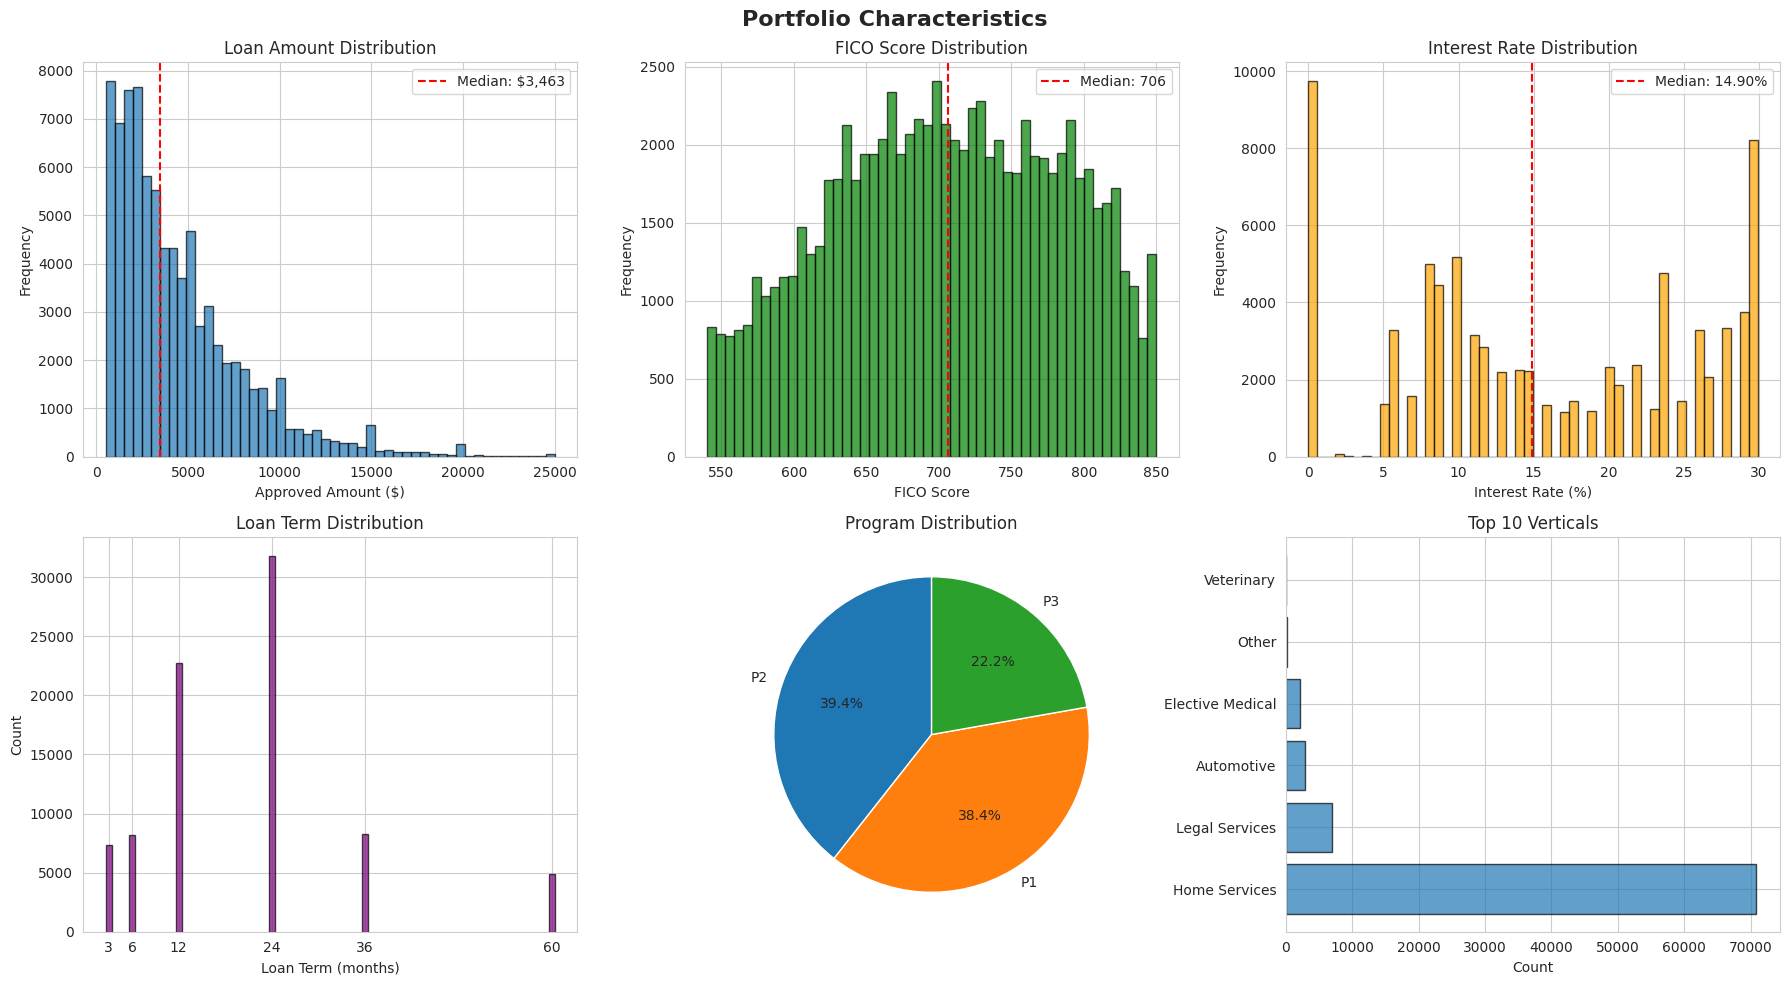


Key Portfolio Metrics:
Total Loans: 83,235
Total Portfolio Value: $373,182,872
Average Loan Size: $4,483
Average FICO Score: 705
Average Interest Rate: 15.88%
Average Loan Term: 20.4 months


In [344]:
# Portfolio characteristics visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Portfolio Characteristics', fontsize=16, fontweight='bold')

# Loan Amount Distribution
axes[0, 0].hist(loan_tape_clean['approved_amount'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Approved Amount ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Loan Amount Distribution')
axes[0, 0].axvline(loan_tape_clean['approved_amount'].median(), color='red', linestyle='--', label=f"Median: ${loan_tape_clean['approved_amount'].median():,.0f}")
axes[0, 0].legend()

# FICO Score Distribution
axes[0, 1].hist(loan_tape_clean['fico_score'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_xlabel('FICO Score')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('FICO Score Distribution')
axes[0, 1].axvline(loan_tape_clean['fico_score'].median(), color='red', linestyle='--', label=f"Median: {loan_tape_clean['fico_score'].median():.0f}")
axes[0, 1].legend()

# Interest Rate Distribution
axes[0, 2].hist(loan_tape_clean['int_rate'] * 100, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[0, 2].set_xlabel('Interest Rate (%)')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Interest Rate Distribution')
axes[0, 2].axvline(loan_tape_clean['int_rate'].median() * 100, color='red', linestyle='--', label=f"Median: {loan_tape_clean['int_rate'].median() * 100:.2f}%")
axes[0, 2].legend()

# Loan Term Distribution
term_counts = loan_tape_clean['loan_term'].value_counts().sort_index()

# set x-axis ticks to only available terms
axes[1, 0].set_xticks(term_counts.index)
axes[1, 0].bar(term_counts.index, term_counts.values, edgecolor='black', alpha=0.7, color='purple')
axes[1, 0].set_xlabel('Loan Term (months)')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Loan Term Distribution')

# Program Distribution
program_counts = loan_tape_clean['program'].value_counts()
axes[1, 1].pie(program_counts.values, labels=program_counts.index, autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Program Distribution')

# Vertical Distribution
vertical_counts = loan_tape_clean['vertical'].value_counts().head(10)
axes[1, 2].barh(range(len(vertical_counts)), vertical_counts.values, edgecolor='black', alpha=0.7)
axes[1, 2].set_yticks(range(len(vertical_counts)))
axes[1, 2].set_yticklabels(vertical_counts.index)
axes[1, 2].set_xlabel('Count')
axes[1, 2].set_title('Top 10 Verticals')

plt.tight_layout()
plt.show()

print("\nKey Portfolio Metrics:")
print(f"Total Loans: {len(loan_tape_clean):,}")
print(f"Total Portfolio Value: ${loan_tape_clean['approved_amount'].sum():,.0f}")
print(f"Average Loan Size: ${loan_tape_clean['approved_amount'].mean():,.0f}")
print(f"Average FICO Score: {loan_tape_clean['fico_score'].mean():.0f}")
print(f"Average Interest Rate: {loan_tape_clean['int_rate'].mean() * 100:.2f}%")
print(f"Average Loan Term: {loan_tape_clean['loan_term'].mean():.1f} months")

### Generate summary statistics by program
* Credit quality: P3<P2<P1
* Younger population: P3 program targets more risk population with lower FICO
* Higher interest rate risk: APR for P3 is much higher (25% vs 18%/8%)
* Lower Balance: approved balance for P3 is lower
* Shorter term: majority P3 are short term loans (12M or less) compared to P1/P2 (24M)

In [345]:
# Generate summary statistics for loan_tape_clean by program and overall
def format_val(x):
    return f"{x:.2f}" if isinstance(x, float) else x

stats = loan_tape_clean.groupby('program').apply(
    lambda g: pd.Series({
        'Loan_Count': g['display_id'].count(),
        'Avg_Loan_Term': g['loan_term'].mean(),
        'Avg_MDR': g['mdr'].mean(),
        'Avg_Int_Rate': g['int_rate'].mean(),
        'Avg_FICO': g['fico_score'].mean(),
        'Avg_Approved_Amount': g['approved_amount'].mean(),
        'Avg_co_amt_est_pct_of_Approved': (g['co_amt_est'] / g['approved_amount']).mean() * 100
    })
)

# Add overall row
overall = pd.DataFrame({
    'Loan_Count': [len(loan_tape_clean)],
    'Avg_Loan_Term': [loan_tape_clean['loan_term'].mean()],
    'Avg_MDR': [loan_tape_clean['mdr'].mean() * 100],
    'Avg_Int_Rate': [loan_tape_clean['int_rate'].mean() * 100],
    'Avg_FICO': [loan_tape_clean['fico_score'].mean()],
    'Avg_Approved_Amount': [loan_tape_clean['approved_amount'].mean()],
    'Avg_co_amt_est_pct_of_Approved': [(loan_tape_clean['co_amt_est'] / loan_tape_clean['approved_amount']).mean() * 100]
}, index=['Overall'])

# Convert MDR and Int Rate to percentage for each program as well
stats['Avg_MDR'] = stats['Avg_MDR'] * 100
stats['Avg_Int_Rate'] = stats['Avg_Int_Rate'] * 100

summary = pd.concat([stats, overall])
summary = summary.applymap(format_val)
summary


,Loan_Count,Avg_Loan_Term,Avg_MDR,Avg_Int_Rate,Avg_FICO,Avg_Approved_Amount,Avg_co_amt_est_pct_of_Approved
P1,31957.00,21.49,4.67,8.05,770.54,5437.32,1.56
P2,32785.00,21.71,5.37,18.20,695.97,4277.80,7.47
P3,18493.00,16.12,7.62,25.32,605.58,3199.85,18.46
Overall,83235.00,20.39,5.60,15.88,704.52,4483.48,7.39


### Key Portfolio Trends- credit quality evolved over time:

1. Program Mix Evolution:
   - P1 (highest quality) has been increasing since 2023 Q2, from ~30% to ~56% of originations
   - P3 (highest risk) has been decreasing since 2022 Q4 peak of ~29% to ~12% in latest quarter
   - P2 has remained relatively stable around 40% until recent decline to ~31%

2. Credit Quality by Program:
   - Stay relatively unchanged

This shift toward higher quality originations (more P1, less P3) since 2023 suggests a more conservative credit strategy being implemented.

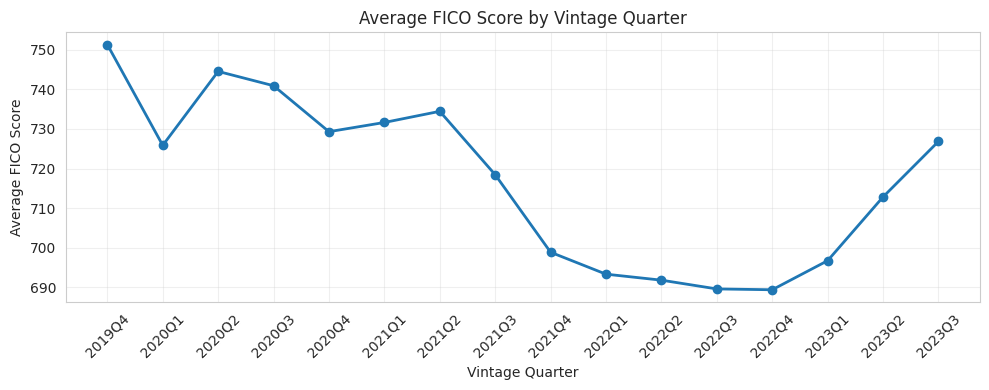

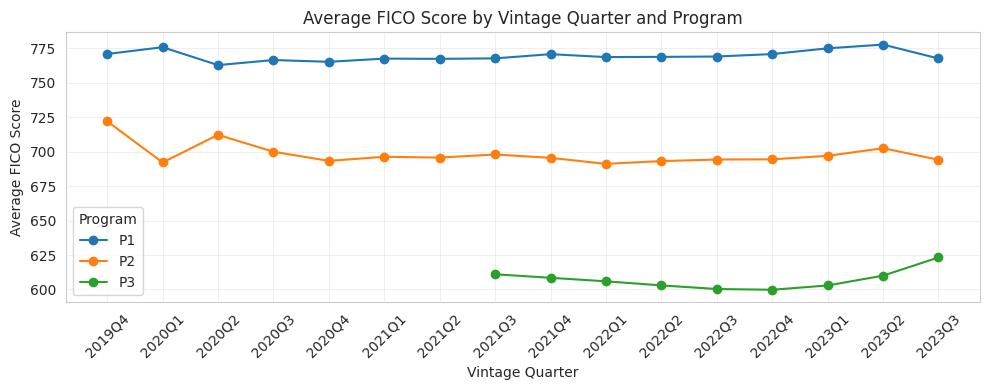

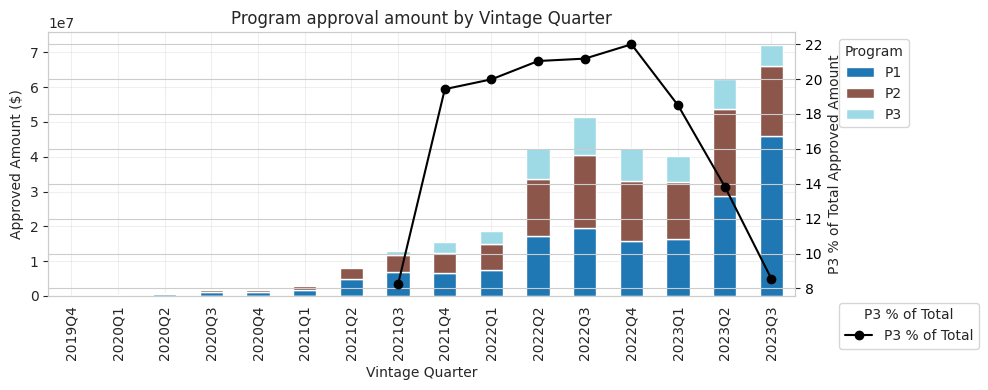

In [337]:
# 1. Average FICO by vintage quarter
# Calculate program composition by vintage quarter
loan_tape_clean['vintage_quarter'] = loan_tape_clean['disbursement_d'].dt.to_period('Q')
avg_fico_by_vintage = loan_tape_clean.groupby('vintage_quarter')['fico_score'].mean()

plt.figure(figsize=(10, 4))
plt.plot(avg_fico_by_vintage.index.astype(str), avg_fico_by_vintage.values, marker='o', linewidth=2)
plt.title('Average FICO Score by Vintage Quarter')
plt.xlabel('Vintage Quarter')
plt.ylabel('Average FICO Score')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Average FICO by vintage quarter and program
avg_fico_by_vintage_prog = loan_tape_clean.groupby(['vintage_quarter', 'program'])['fico_score'].mean().unstack()

plt.figure(figsize=(10, 4))
for prog in avg_fico_by_vintage_prog.columns:
    plt.plot(avg_fico_by_vintage_prog.index.astype(str), avg_fico_by_vintage_prog[prog], marker='o', label=prog)
plt.title('Average FICO Score by Vintage Quarter and Program')
plt.xlabel('Vintage Quarter')
plt.ylabel('Average FICO Score')
plt.xticks(rotation=45)
plt.legend(title='Program')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Program approval amount by vintage quarter

#add a secondary y-axis showing the percentage of P3 total approved amount per vintage quarter
p3_totals = loan_tape_clean[loan_tape_clean['program'] == 'P3'].groupby('vintage_quarter')['approved_amount'].sum()
p3_percentage = p3_totals / loan_tape_clean.groupby('vintage_quarter')['approved_amount'].sum() * 100

fig, ax1 = plt.subplots(figsize=(10, 4))

# Plot the stacked bar chart
loan_tape_clean.groupby(['vintage_quarter', 'program'])['approved_amount'].sum().unstack(fill_value=0).plot(kind='bar', stacked=True, ax=ax1, colormap='tab20')
ax1.set_title('Program approval amount by Vintage Quarter')
ax1.set_xlabel('Vintage Quarter')
ax1.set_ylabel('Approved Amount ($)')
ax1.legend(title='Program', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(alpha=0.3)

# Create a secondary y-axis
ax2 = ax1.twinx()
ax2.plot(p3_percentage.index.astype(str), p3_percentage.values, marker='o', color='black', label='P3 % of Total')
ax2.set_ylabel('P3 % of Total Approved Amount')
ax2.tick_params(axis='y', labelcolor='black')
ax2.legend(title='P3 % of Total', bbox_to_anchor=(1.05, 0), loc='upper left')

plt.tight_layout()
plt.show()


## 4. Merge hist and static table, calculate additional columns

In [346]:
# Merge loan tape with performance data
df = loan_perf_clean.merge(
    loan_tape_clean[['display_id', 'disbursement_d', 'loan_term', 'fico_score', 'approved_amount', 'program', 'vertical','vintage_quarter']],
    on='display_id',
    how='inner'
)

print(f"Merged dataset shape: {df.shape}")
df.head()

# Calculate loan age in months
df['loan_age_months'] = ((df['report_date'] - df['disbursement_d']).dt.days / 30.44).round().astype(int)

# Create vintage (year-month of disbursement)
df['vintage'] = df['disbursement_d'].dt.to_period('M')

# Create disbursement year and quarter for cohort analysis
df['disbursement_year'] = df['disbursement_d'].dt.year
df['disbursement_quarter'] = df['disbursement_d'].dt.to_period('Q')
df['disbursement_year'] = df['disbursement_d'].dt.to_period('Y')

df=df[df.loan_status!='WRITTEN_OFF']

print("\nVintage Distribution:")
print(df['vintage'].value_counts().sort_index().head(10))

Merged dataset shape: (1039585, 16)

Vintage Distribution:
vintage
2019-10     196
2019-11      96
2019-12     141
2020-01     460
2020-02     584
2020-03    1625
2020-04    1505
2020-05    2563
2020-06    3320
2020-07    5546
Freq: M, Name: count, dtype: int64


In [ ]:
# Create delinquency status buckets (standard mortgage classification)
def categorize_delinquency(days):
    if days == 0:
        return 'CURRENT'
    elif days <= 30:
        return '1-30 DPD'
    elif days <= 60:
        return '31-60 DPD'
    elif days <= 90:
        return '61-90 DPD'
    elif days <= 120:
        return '91-120 DPD'
    else:
        return '120+ DPD'

# Only assign delinquency bucket for active loans (upb > 0), else set as NaN
# Assign delinquency bucket only for active loans (upb > 0), else set as NaN
df['delinquency_bucket'] = np.where(
    df['upb'] > 0,
    df['days_delinquent'].apply(categorize_delinquency),
    np.where(df['loan_status'].isin(['CHARGED_OFF']), 'Default',
             np.where(df['loan_status'].isin(['PAID_OFF']) | (df['upb'] == 0) & (df['loan_term'] - df['loan_age_months'] < 2), 'Prepaid',
                     'CURRENT'))
)

# Create delinquency severity indicators only for active loans (upb > 0)
df['is_delinquent'] = (df['upb'] > 0) & (df['days_delinquent'] > 0)
df['is_30plus'] = (df['upb'] > 0) & (df['days_delinquent'] > 30)
df['is_60plus'] = (df['upb'] > 0) & (df['days_delinquent'] > 60)
df['is_90plus'] = (df['upb'] > 0) & (df['days_delinquent'] > 90)

# For each loan, create a column 'cum_co_amt' that is 0 until co_amt appears, then fills forward that value for all subsequent rows

# Sort data by loan ID and report date 
df = df.sort_values(['display_id', 'report_date'])
# Get previous month's UPB
df['prev_upb'] = df.groupby('display_id')['upb'].shift(1)

#Get cumulative charge off amount
df['cum_co_loss'] = df['co_amt']
df['upb_at_dft'] = np.where(df['charge_off_date'].dt.to_period('M') == df['report_date'].dt.to_period('M'), df['prev_upb'], 0)
df['loss_at_dft'] = np.where(df['charge_off_date'].dt.to_period('M') == df['report_date'].dt.to_period('M'), df['co_amt'], 0)
df['cum_charge_off'] = df.groupby('display_id')['upb_at_dft'].transform(lambda x: x.where(x > 0).ffill().fillna(0))

# Create a flag for if loan was ever 30+ days delinquent in any prior period
df['ever_D30'] = df.groupby('display_id')['is_30plus'].transform(lambda x: x.cummax().fillna(0)).astype(int)
df['ever_D60'] = df.groupby('display_id')['is_60plus'].transform(lambda x: x.cummax().fillna(0)).astype(int)
df['ever_D90'] = df.groupby('display_id')['is_90plus'].transform(lambda x: x.cummax().fillna(0)).astype(int)

# Get the earliest 30+ DPD occurrence for each loan and record the UPB at that time
df['first_D30_upb'] = df.groupby('display_id').apply(
    lambda x: x.loc[x['is_30plus'].idxmax(), 'prev_upb'] if x['is_30plus'].any() else 0
).values

df['next_delinquency_bucket'] = df.groupby('display_id')['delinquency_bucket'].shift(-1)
df['next_loan_status'] = df.groupby('display_id')['loan_status'].shift(-1)

print("\nDelinquency Status Distribution:")
print(df['delinquency_bucket'].value_counts())

print("\nDelinquency Severity Rates:")
print(f"Any Delinquency: {df['is_delinquent'].mean():.2%}")
print(f"30+ DPD: {df['is_30plus'].mean():.2%}")
print(f"60+ DPD: {df['is_60plus'].mean():.2%}")
print(f"90+ DPD: {df['is_90plus'].mean():.2%}")


Delinquency Status Distribution:
delinquency_bucket
CURRENT       571352
Prepaid       313268
Default        57023
1-30 DPD       37809
31-60 DPD      14156
61-90 DPD      10276
91-120 DPD      8050
120+ DPD         955
Name: count, dtype: int64

Delinquency Severity Rates:
Any Delinquency: 7.03%
30+ DPD: 3.30%
60+ DPD: 1.90%
90+ DPD: 0.89%


## 4. Create Delinquency, CumDft, CumLoss Charts

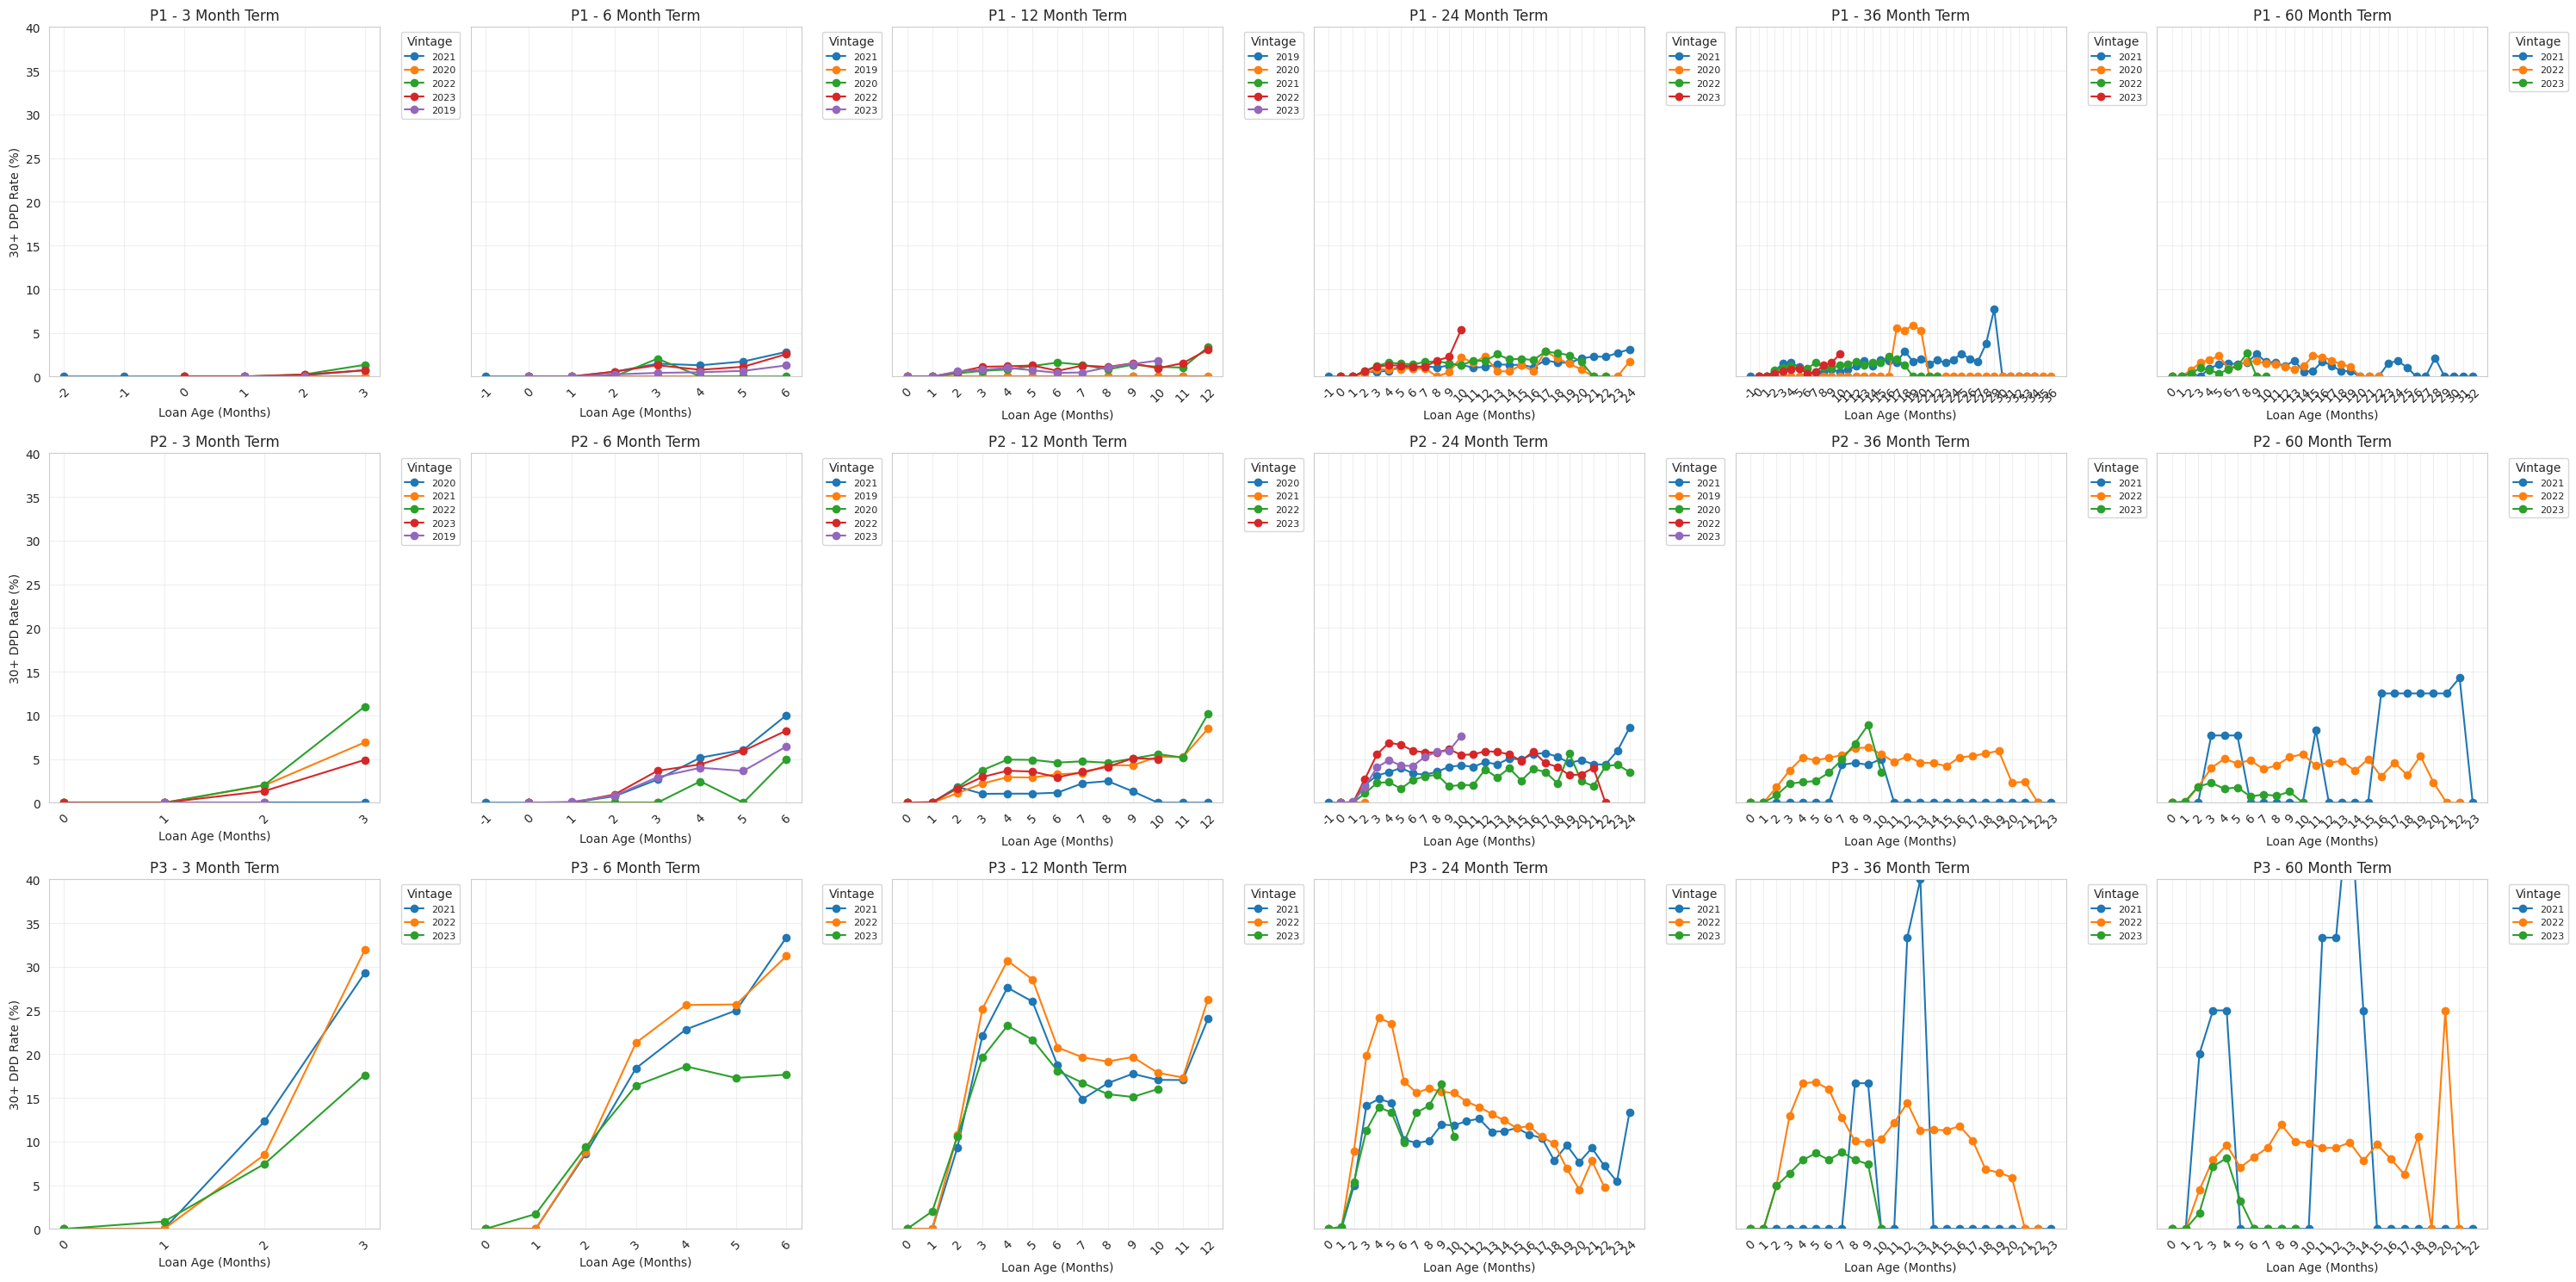

In [350]:
# Calculate 30+ DPD rate time series by report month, vintage quarter, program, and term
# Filter out observations where loan age exceeds loan term
d30plus_term_series = (
    df[(df['upb'] > 0) & (df['loan_term'] >= df['loan_age_months'])]
    .groupby(['loan_age_months', 'disbursement_year', 'program', 'loan_term'])['is_30plus']
    .mean()
    .mul(100)
    .reset_index()
    .rename(columns={'is_30plus': 'dpd_30plus_rate', 'disbursement_year': 'vintage'})
)

# Plot: one row per program, one column per term
terms = sorted(df['loan_term'].unique())
programs = d30plus_term_series['program'].unique()

fig, axes = plt.subplots(len(programs), len(terms), figsize=(5*len(terms), 5*len(programs)), sharey=True)

for i, prog in enumerate(programs):
    for j, term in enumerate(terms):
        prog_term_data = d30plus_term_series[(d30plus_term_series['program'] == prog) & 
                                           (d30plus_term_series['loan_term'] == term)]
        
        for vintage in prog_term_data['vintage'].unique():
            data = prog_term_data[prog_term_data['vintage'] == vintage]
            if not data.empty:
                axes[i,j].plot(data['loan_age_months'].astype(str), data['dpd_30plus_rate'], 
                             marker='o', label=f'{vintage}')
        
        axes[i,j].set_title(f'{prog} - {term} Month Term')
        axes[i,j].set_xlabel('Loan Age (Months)')
        if j == 0:
            axes[i,j].set_ylabel('30+ DPD Rate (%)')
        y_lim = 5 if prog == 'P1' else 10 if prog=='P2' else 40
        axes[i,j].set_ylim(bottom=0, top=y_lim)
        axes[i,j].tick_params(axis='x', rotation=45)
        axes[i,j].legend(title='Vintage', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        axes[i,j].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [364]:
df['ever_D30'].unique()

array([0, True], dtype=object)

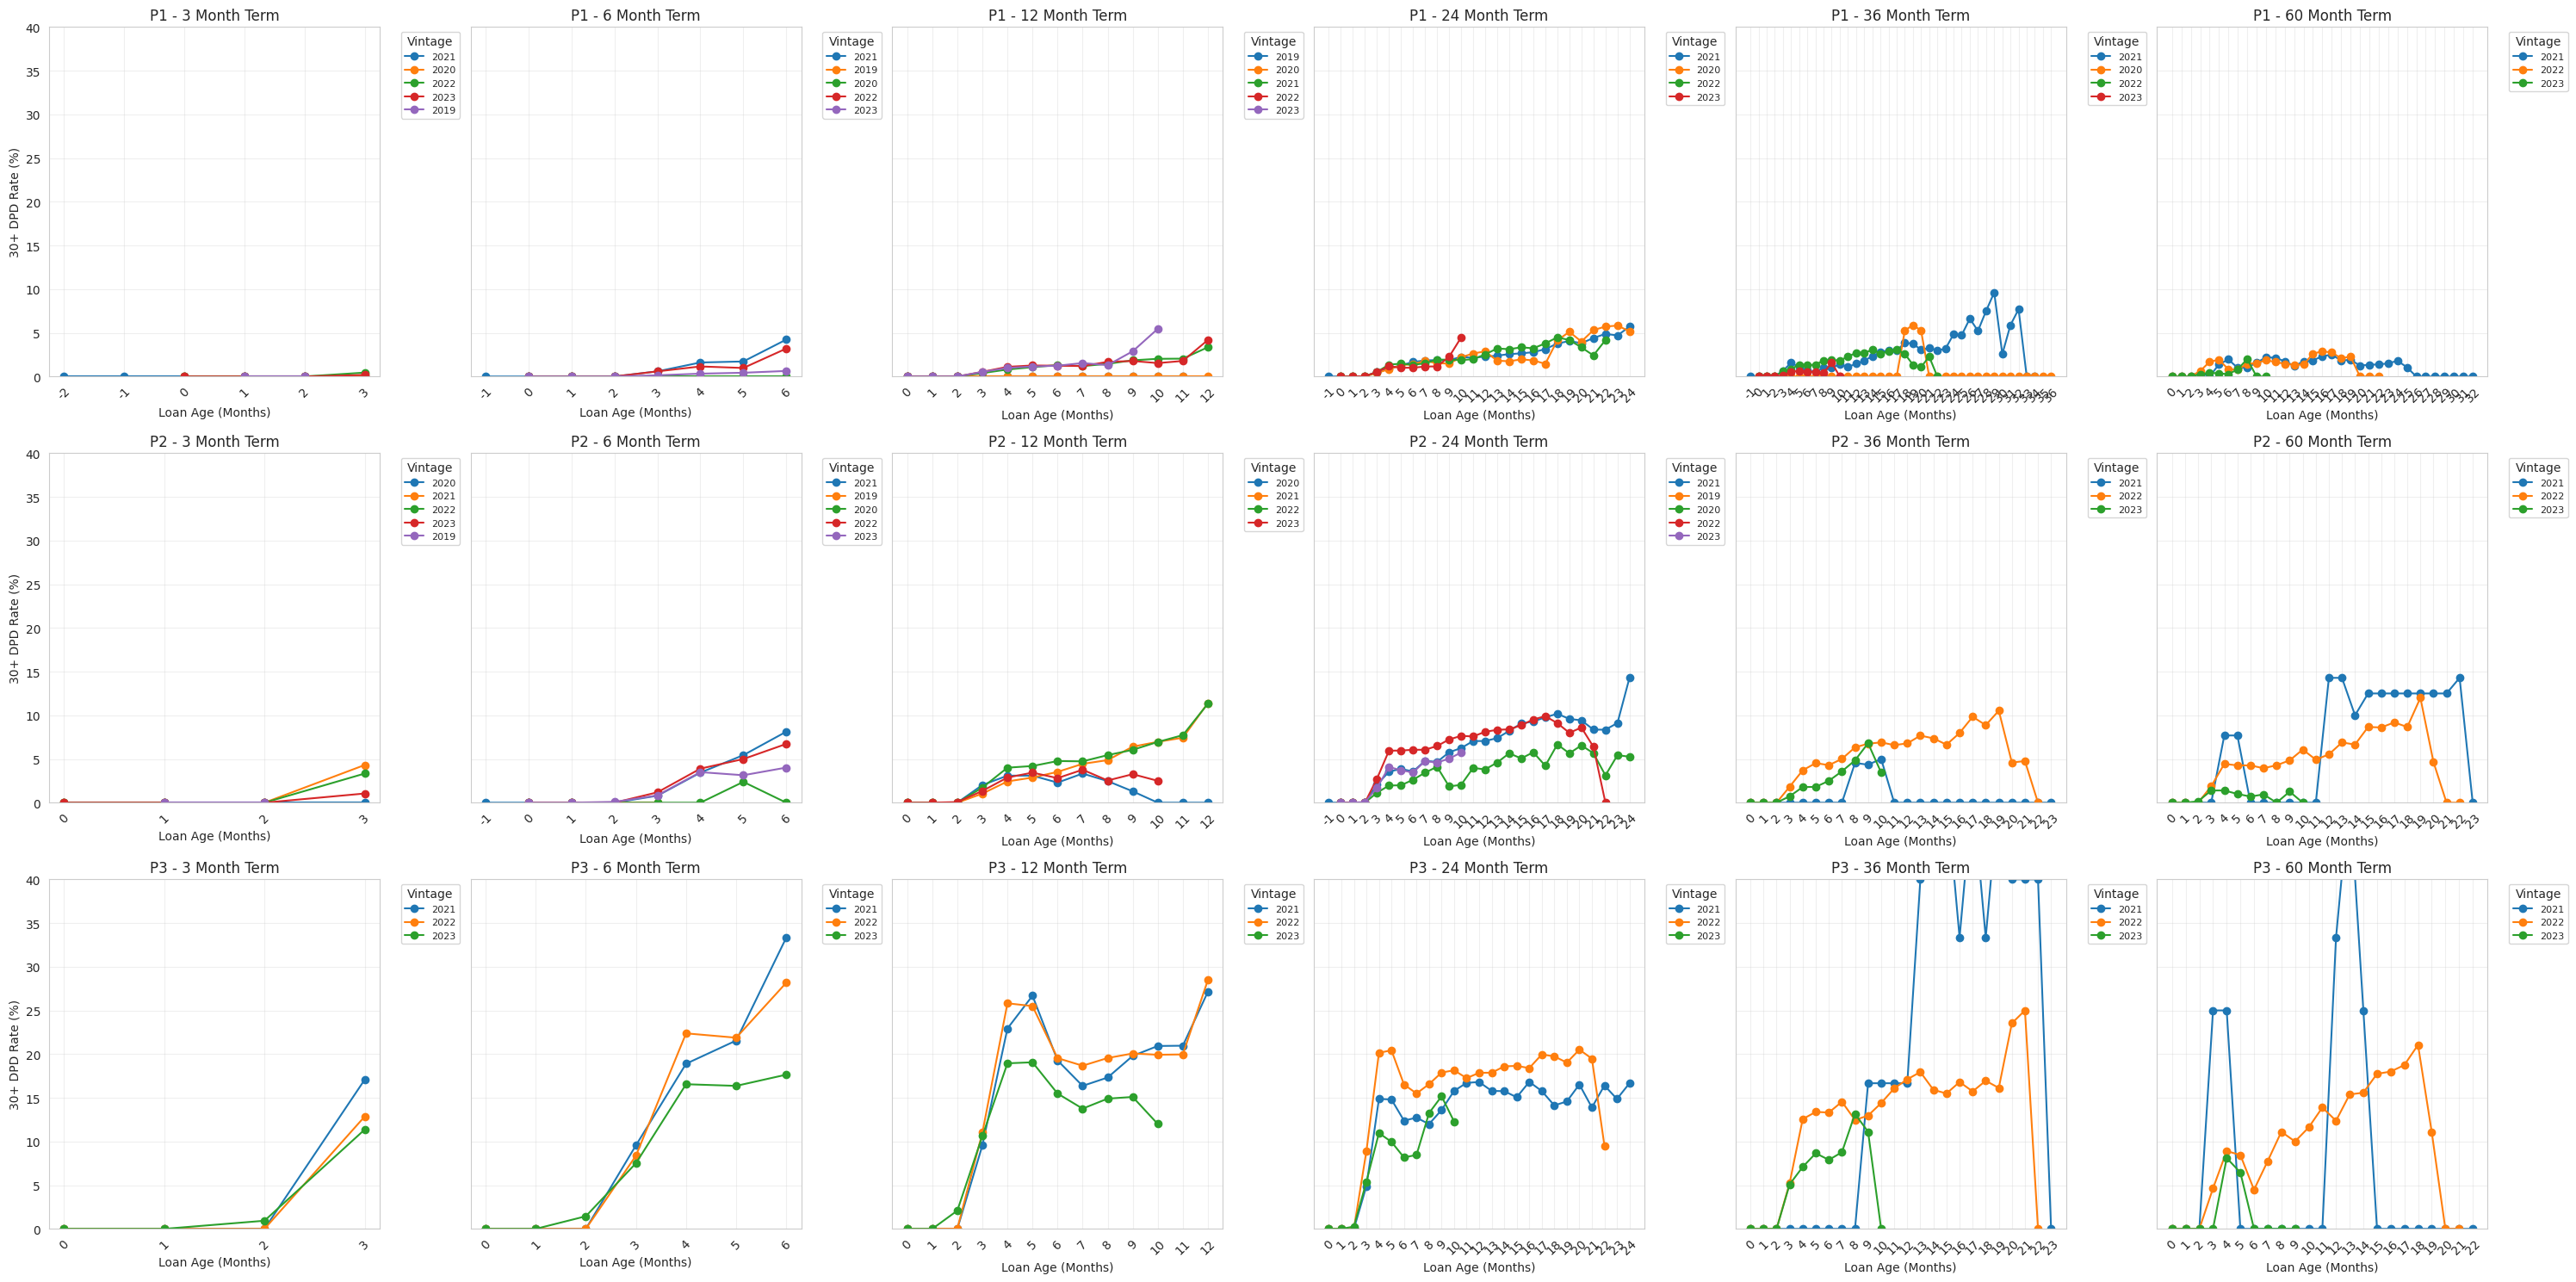

In [369]:
# Calculate 30+ DPD rate time series by report month, vintage quarter, program, and term
# Filter out observations where loan age exceeds loan term
everD30_term_series = (
    df[(df['upb'] > 0) & (df['loan_term'] >= df['loan_age_months']) ]
    .groupby(['loan_age_months', 'disbursement_year', 'program', 'loan_term'])['ever_D30']
    .mean()
    .mul(100)
    .reset_index()
    .rename(columns={'ever_D30': 'ever_D30_pct', 'disbursement_year': 'vintage'})
)

# Plot: one row per program, one column per term
terms = sorted(df['loan_term'].unique())
programs = everD30_term_series['program'].unique()

fig, axes = plt.subplots(len(programs), len(terms), figsize=(5*len(terms), 5*len(programs)), sharey=True)

for i, prog in enumerate(programs):
    for j, term in enumerate(terms):
        prog_term_data = everD30_term_series[(everD30_term_series['program'] == prog) & 
                                           (everD30_term_series['loan_term'] == term)]

        for vintage in prog_term_data['vintage'].unique():
            data = prog_term_data[prog_term_data['vintage'] == vintage]
            if not data.empty:
                axes[i,j].plot(data['loan_age_months'].astype(str), data['ever_D30_pct'], 
                             marker='o', label=f'{vintage}')
        
        axes[i,j].set_title(f'{prog} - {term} Month Term')
        axes[i,j].set_xlabel('Loan Age (Months)')
        if j == 0:
            axes[i,j].set_ylabel('30+ DPD Rate (%)')
        y_lim = 5 if prog == 'P1' else 10 if prog=='P2' else 40
        axes[i,j].set_ylim(bottom=0, top=y_lim)
        axes[i,j].tick_params(axis='x', rotation=45)
        axes[i,j].legend(title='Vintage', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        axes[i,j].grid(alpha=0.3)

plt.tight_layout()
plt.show()


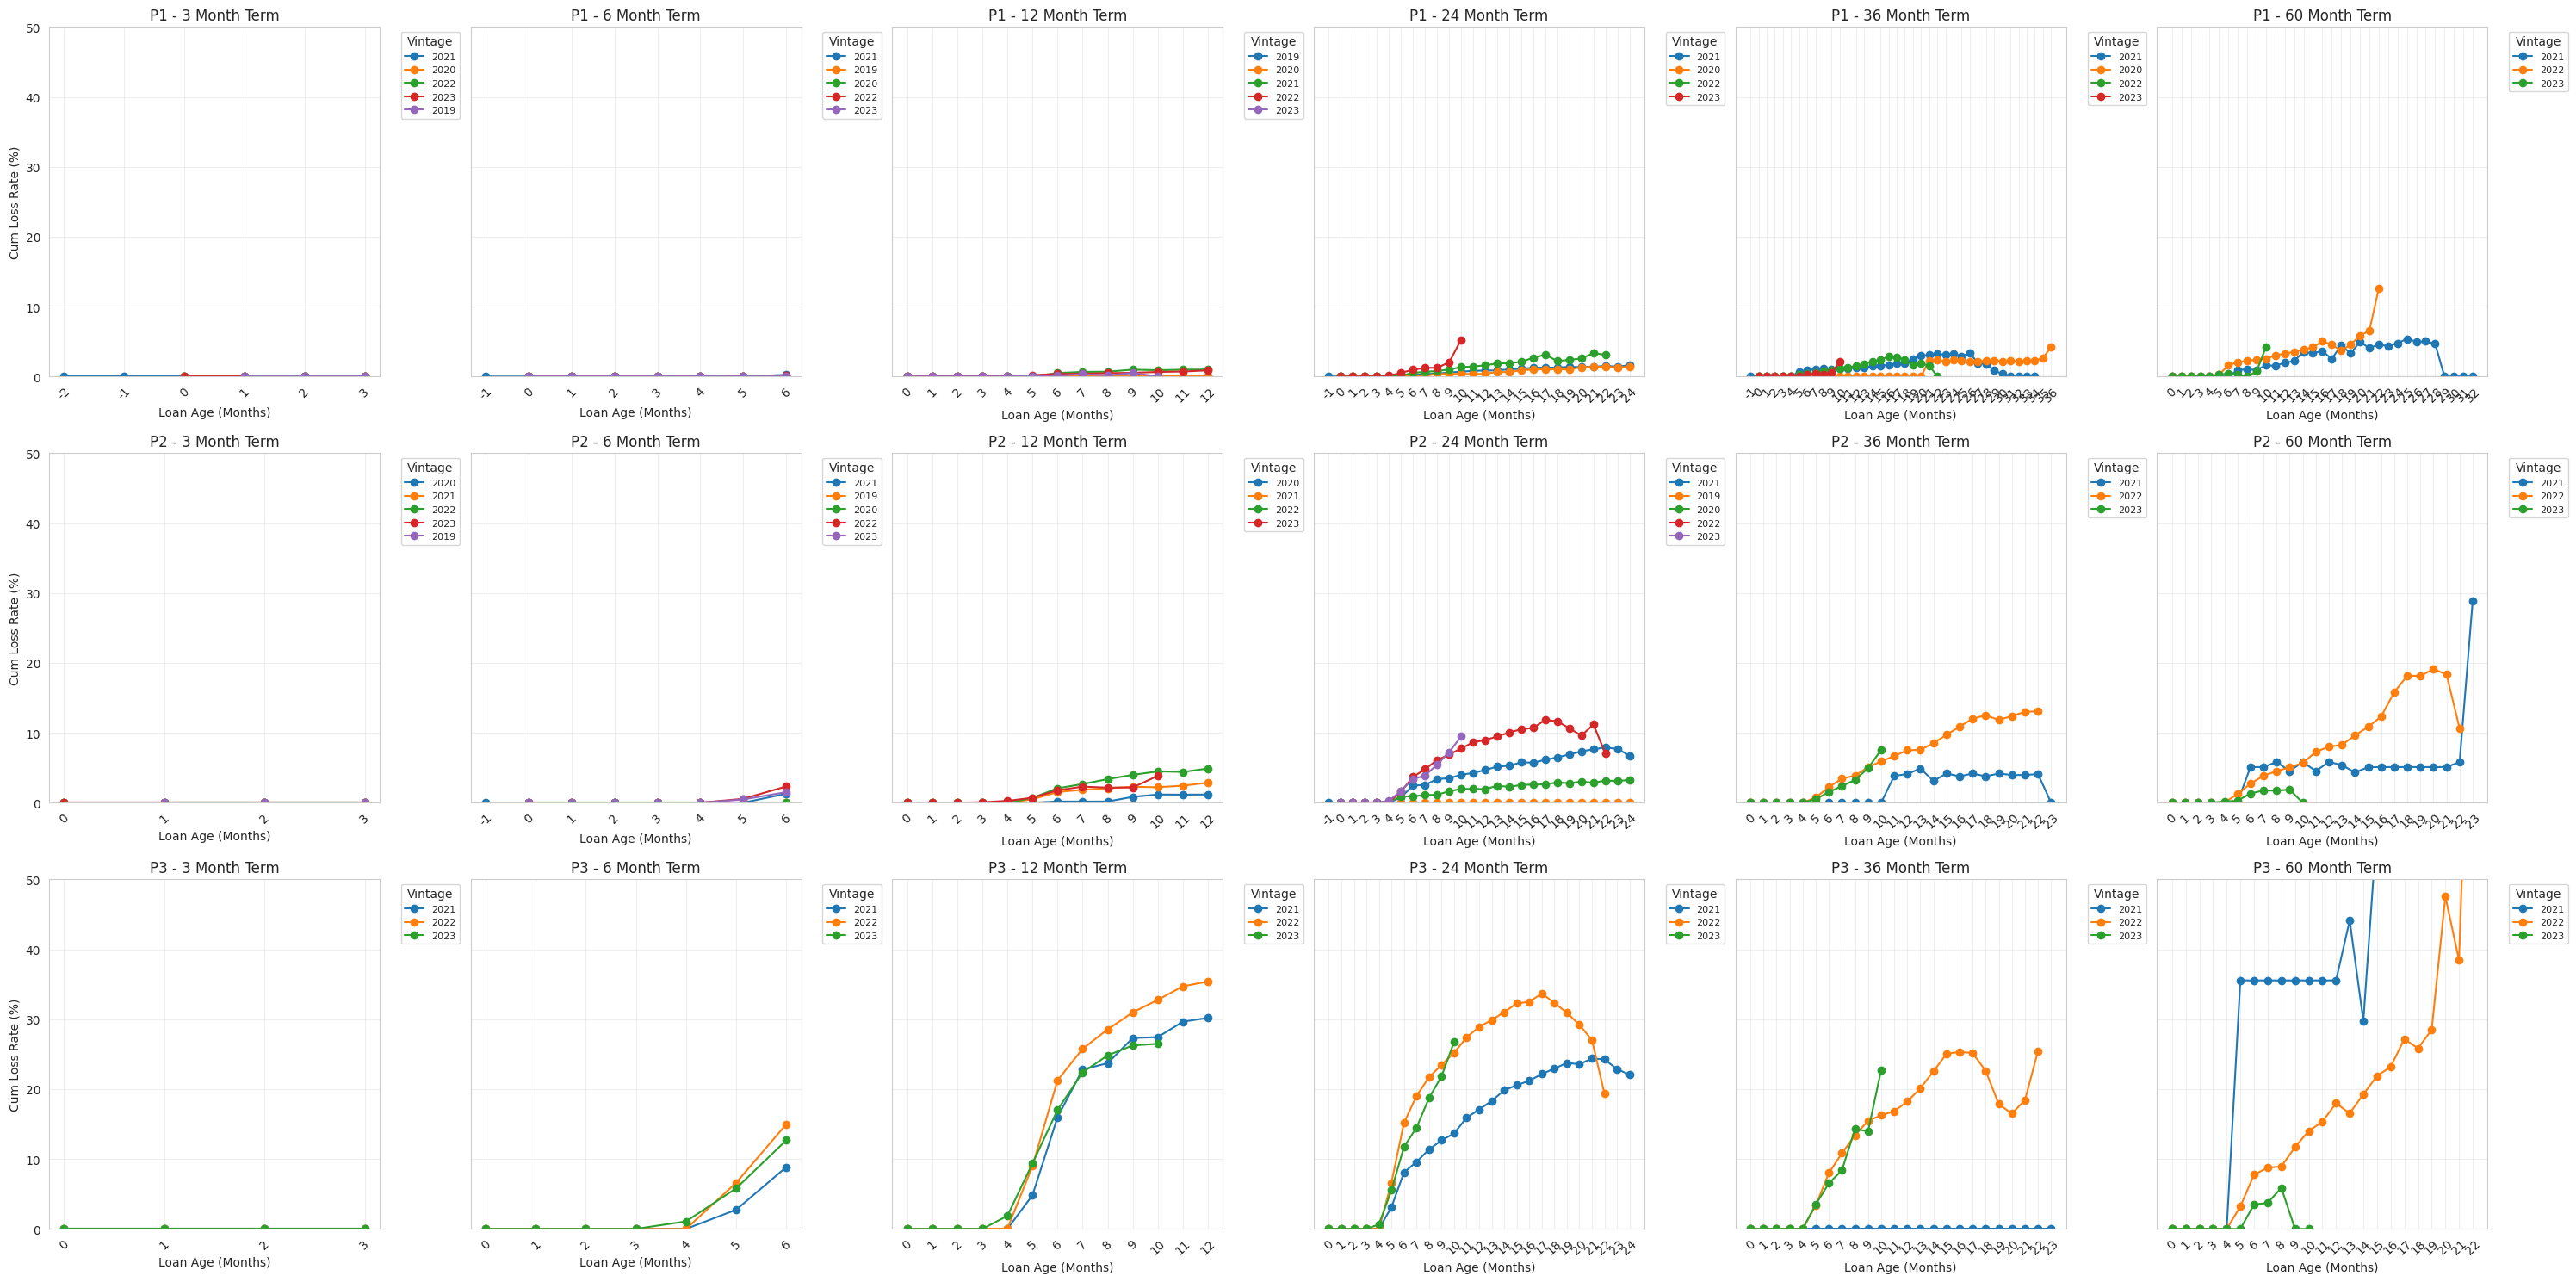

In [316]:
# Calculate 30+ DPD rate time series by report month, vintage quarter, program, and term
d_loss_series = (
    df[df.loan_term>=df.loan_age_months].groupby(['loan_age_months', 'disbursement_year', 'program', 'loan_term'])[["cum_co_loss"]]
    .sum()
)

# Plot: one row, one chart per program, each chart shows cumulative loss by vintage
programs = sorted(df['program'].unique())
# Calculate cum charge off amount as percentage of original amount
d_loss_series['cum_loss_rate'] = d_loss_series['cum_co_loss'] / df[df.loan_term>=df.loan_age_months].groupby(['loan_age_months', 'disbursement_year', 'program', 'loan_term'])['approved_amount'].sum()*100
d_loss_series = d_loss_series.reset_index().rename(columns={'disbursement_year': 'vintage'})

# Plot: one row per program, one column per term
terms = sorted(df['loan_term'].unique())


fig, axes = plt.subplots(len(programs), len(terms), figsize=(5*len(terms), 5*len(programs)), sharey=True)

for i, prog in enumerate(programs):
    for j, term in enumerate(terms):
        prog_term_data = d_loss_series[(d_loss_series['program'] == prog) & 
                                       (d_loss_series['loan_term'] == term)]

        for vintage in prog_term_data['vintage'].unique():
            data = prog_term_data[prog_term_data['vintage'] == vintage]
            if not data.empty:
                axes[i,j].plot(data['loan_age_months'].astype(str), data['cum_loss_rate'], 
                             marker='o', label=f'{vintage}')
        
        axes[i,j].set_title(f'{prog} - {term} Month Term')
        axes[i,j].set_xlabel('Loan Age (Months)')
        if j == 0:
            axes[i,j].set_ylabel('Cum Loss Rate (%)')
        axes[i,j].set_ylim(bottom=0, top=50)
        axes[i,j].tick_params(axis='x', rotation=45)
        axes[i,j].legend(title='Vintage', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        axes[i,j].grid(alpha=0.3)

plt.tight_layout()
plt.show()


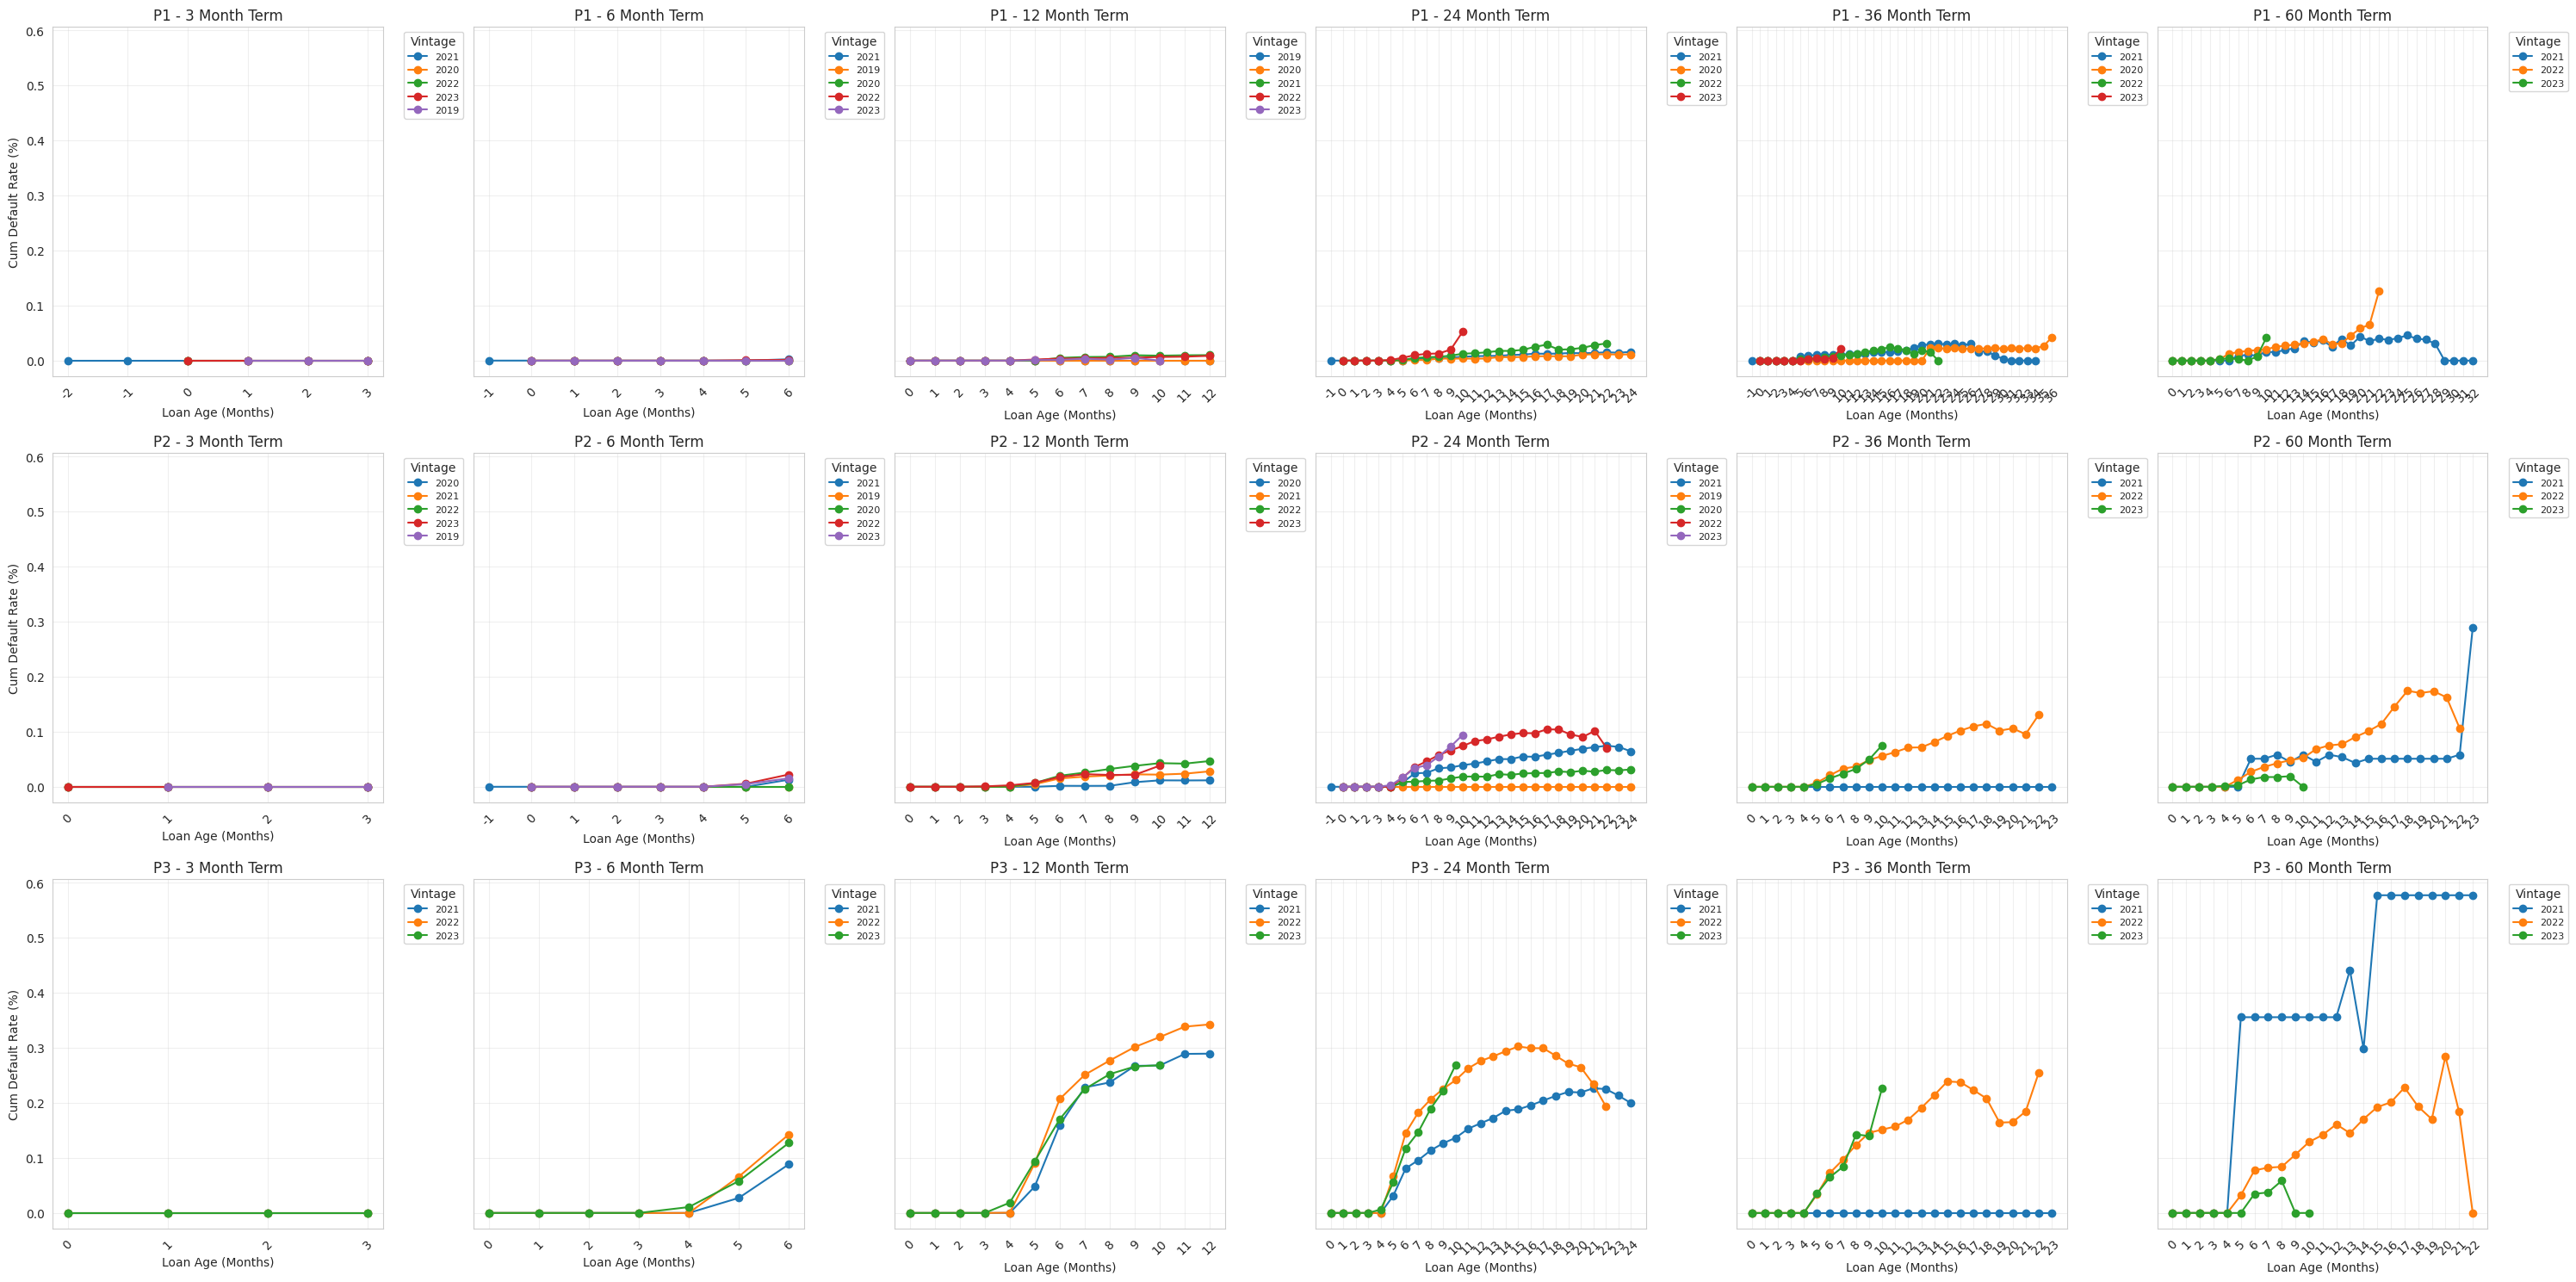

In [317]:
# Calculate cum default rate time series by report month, vintage quarter, program, and term
d_loss_series = (
    df[df['loan_age_months'] <= df['loan_term']].groupby(['loan_age_months', 'disbursement_year', 'program', 'loan_term'])[["cum_charge_off"]]
    .sum()
)

# Plot: one row, one chart per program, each chart shows cumulative loss by vintage
programs = sorted(df['program'].unique())
# Calculate cum charge off amount as percentage of original amount
d_loss_series['cum_loss_rate'] = d_loss_series['cum_charge_off'] / df.groupby(['loan_age_months', 'disbursement_year', 'program', 'loan_term'])['approved_amount'].sum()
d_loss_series = d_loss_series.reset_index().rename(columns={'disbursement_year': 'vintage'})

# Plot: one row per program, one column per term
terms = sorted(df['loan_term'].unique())


fig, axes = plt.subplots(len(programs), len(terms), figsize=(5*len(terms), 5*len(programs)), sharey=True)

for i, prog in enumerate(programs):
    for j, term in enumerate(terms):
        prog_term_data = d_loss_series[(d_loss_series['program'] == prog) & 
                                       (d_loss_series['loan_term'] == term)]

        for vintage in prog_term_data['vintage'].unique():
            data = prog_term_data[prog_term_data['vintage'] == vintage]
            if not data.empty:
                axes[i,j].plot(data['loan_age_months'].astype(str), data['cum_loss_rate'], 
                             marker='o', label=f'{vintage}')
        
        axes[i,j].set_title(f'{prog} - {term} Month Term')
        axes[i,j].set_xlabel('Loan Age (Months)')
        if j == 0:
            axes[i,j].set_ylabel('Cum Default Rate (%)')
        axes[i,j].tick_params(axis='x', rotation=45)
        axes[i,j].legend(title='Vintage', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        axes[i,j].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [318]:
# almost 100% severity
(df.groupby(['program'])["loss_at_dft"].sum())/(df.groupby(['program'])["upb_at_dft"].sum())
# (df[df['loan_age_months'] <= df['loan_term']].groupby(['program', 'loan_term'])[["upb_at_dft"]]
#     .sum())/(df[df['loan_age_months'] <= df['loan_term']].groupby(['program', 'loan_term'])[["loss_at_dft"]].sum())


program
P1    0.997186
P2    0.997919
P3    0.999819
dtype: float64

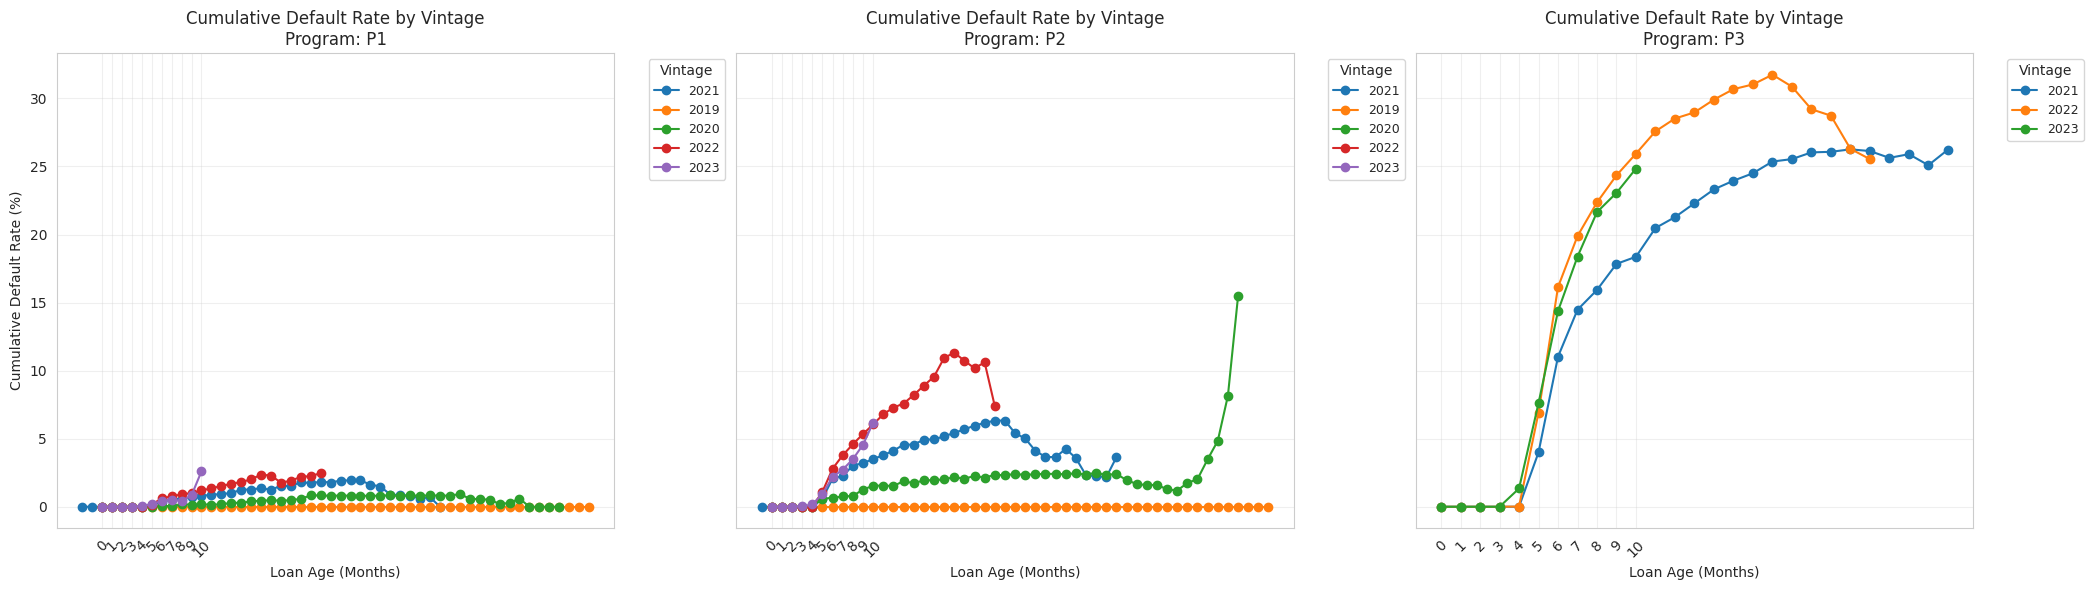

In [324]:

# Calculate cumulative charge off amount time series by loan age, vintage and program
d_default_series = (
    df.groupby(['loan_age_months', 'disbursement_year', 'program'])[['cum_co_loss']]
    .sum()
)

# Plot: one row, one chart per program, each chart shows cumulative default by vintage
programs = sorted(df['program'].unique())
# Calculate cum charge off amount as percentage of original amount
d_default_series['cum_loss_rate'] = 100*d_default_series['cum_co_loss'] / df.groupby(['loan_age_months', 'disbursement_year', 'program'])['approved_amount'].sum()
d_default_series = d_default_series.reset_index().rename(columns={'disbursement_year': 'vintage'})
fig, axes = plt.subplots(1, len(programs), figsize=(7 * len(programs), 6), sharey=True)

if len(programs) == 1:
    axes = [axes]

for i, prog in enumerate(programs):
    prog_data = d_default_series[d_default_series['program'] == prog]
    for vintage in prog_data['vintage'].unique():
        data = prog_data[prog_data['vintage'] == vintage]
        if not data.empty:
            axes[i].plot(data['loan_age_months'].astype(str), data['cum_loss_rate'], marker='o', label=f'{vintage}')
    axes[i].set_title(f'Cumulative Default Rate by Vintage\nProgram: {prog}')
    axes[i].set_xlabel('Loan Age (Months)')
    if i == 0:
        axes[i].set_ylabel('Cumulative Default Rate (%)')
    axes[i].set_xticks(data['loan_age_months'].astype(str).unique())
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend(title='Vintage', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Historical Roll Rate Analysis

Roll rates show the probability of loans transitioning from one delinquency state to another (or to default/prepay) in the next period.

In [325]:
# status distribution when loans' upb becomes 0

df[(df['prev_upb'] != 0) & (df['upb'] == 0)].loan_status.value_counts()

loan_status
PAID_OFF       27172
CHARGED_OFF     7253
CURRENT         3184
DELINQUENT        16
Name: count, dtype: int64

In [228]:
df[(df['prev_upb'] != 0) & (df['upb'] == 0) & (df['loan_status'] == 'WRITTEN_OFF')].head()

,display_id,report_date,co_amt,charge_off_date,loan_status,upb,paid_principal,paid_interest,days_delinquent,disbursement_d,loan_term,fico_score,approved_amount,program,vertical,loan_age_months,vintage,disbursement_year,disbursement_quarter,delinquency_bucket,is_delinquent,is_30plus,is_60plus,is_90plus,prev_upb,cum_co_loss,upb_at_dft,loss_at_dft,cum_charge_off
1039438,00052567-0-aa23e02d,2023-10-31,0.0,NaT,WRITTEN_OFF,0.0,0.0,0.0,0,2023-09-29,3,850,14000.0,P1,Home Services,1,2023-09,2023,2023Q3,NaN,False,False,False,False,14000.0,0.0,0.0,0.0,0.0
883959,00221721-0-21a2f5ee,2023-02-28,0.0,NaT,WRITTEN_OFF,0.0,0.0,0.0,0,2023-02-03,24,595,5000.0,P3,Legal Services,1,2023-02,2023,2023Q1,NaN,False,False,False,False,NaN,0.0,0.0,0.0,0.0
1019987,0040b1e5-0-55d4bbe9,2023-09-30,0.0,NaT,WRITTEN_OFF,0.0,0.0,0.0,0,2023-07-19,12,787,1922.0,P2,Home Services,2,2023-07,2023,2023Q3,NaN,False,False,False,False,1922.0,0.0,0.0,0.0,0.0
436325,004c09d2,2022-05-31,0.0,NaT,WRITTEN_OFF,0.0,0.0,0.0,0,2022-05-03,24,684,14500.0,P2,Legal Services,1,2022-05,2022,2022Q2,NaN,False,False,False,False,NaN,0.0,0.0,0.0,0.0
700877,005b6ea0,2022-09-30,0.0,NaT,WRITTEN_OFF,0.0,0.0,0.0,0,2022-09-14,24,728,4500.0,P2,Legal Services,1,2022-09,2022,2022Q3,NaN,False,False,False,False,NaN,0.0,0.0,0.0,0.0


In [268]:

roll_rate_data = df[df['next_delinquency_bucket'].notna()].copy()

print(f"Roll rate analysis dataset: {roll_rate_data.shape}")
print(f"\nNext state distribution:")
print(roll_rate_data['next_delinquency_bucket'].value_counts())

Roll rate analysis dataset: (936220, 32)

Next state distribution:
next_delinquency_bucket
CURRENT       495768
Prepaid       312596
Default        57023
1-30 DPD       37396
31-60 DPD      14156
61-90 DPD      10276
91-120 DPD      8050
120+ DPD         955
Name: count, dtype: int64


In [269]:
roll_rate_data['next_delinquency_bucket'].value_counts()

next_delinquency_bucket
CURRENT       495768
Prepaid       312596
Default        57023
1-30 DPD       37396
31-60 DPD      14156
61-90 DPD      10276
91-120 DPD      8050
120+ DPD         955
Name: count, dtype: int64

In [326]:
# Calculate both count-based and UPB-weighted roll rate matrices for comparison


roll_rate_data=roll_rate_data[roll_rate_data.delinquency_bucket.isin(['CURRENT','1-30 DPD','31-60 DPD','61-90 DPD','91-120 DPD','120+ DPD'])]
# Calculate count-based roll rate matrix
roll_rate_count = pd.crosstab(
    roll_rate_data['delinquency_bucket'],
    roll_rate_data['next_delinquency_bucket'],
    normalize='index'
) * 100

# Calculate UPB-weighted roll rate matrix
roll_rate_upb = pd.crosstab(
    roll_rate_data['delinquency_bucket'],
    roll_rate_data['next_delinquency_bucket'],
    values=roll_rate_data['upb'],
    aggfunc='sum'
)

# Calculate row totals for UPB
row_totals_upb = roll_rate_upb.sum(axis=1)

# Normalize by row to get percentages
roll_rate_matrix = roll_rate_upb.div(row_totals_upb, axis=0) * 100

# Reorder columns for better visualization
state_order = ['CURRENT', '1-30 DPD', '31-60 DPD', '61-90 DPD', '91-120 DPD', '120+ DPD', 'Prepaid', 'Default']
existing_states = [s for s in state_order if s in roll_rate_matrix.columns]
roll_rate_matrix = roll_rate_matrix[existing_states]
roll_rate_count = roll_rate_count[existing_states]

print("\n" + "=" * 100)
print("UPB-WEIGHTED Roll Rate Matrix (% of balance/UPB transitioning from row state to column state):")
print("=" * 100)
print(roll_rate_matrix.round(2))


print("=" * 100)
print("COUNT-BASED Roll Rate Matrix (% of loan count transitioning from row state to column state):")
print("=" * 100)
print(roll_rate_count.round(2))


UPB-WEIGHTED Roll Rate Matrix (% of balance/UPB transitioning from row state to column state):
next_delinquency_bucket  CURRENT  1-30 DPD  31-60 DPD  61-90 DPD  91-120 DPD  \
delinquency_bucket                                                             
1-30 DPD                   28.48     36.69      31.92       0.62        0.01   
120+ DPD                    0.98      0.13        NaN       0.18        0.82   
31-60 DPD                   6.69      8.27      13.10      69.01        1.48   
61-90 DPD                   2.75      1.84       2.48       9.88       78.54   
91-120 DPD                  0.95      0.52       0.35       1.38        4.51   
CURRENT                    93.47      4.06       0.13       0.01        0.00   

next_delinquency_bucket  120+ DPD  Prepaid  Default  
delinquency_bucket                                   
1-30 DPD                     0.01     2.22     0.06  
120+ DPD                     9.80     0.60    87.50  
31-60 DPD                    0.06     1.34     

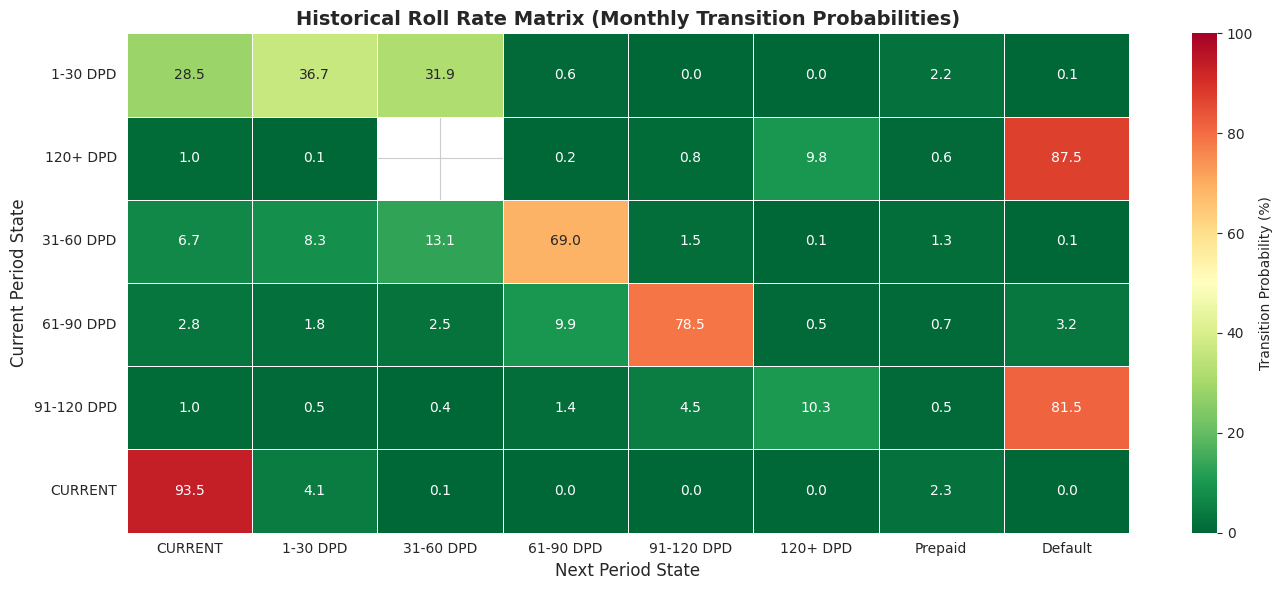

In [327]:
# Visualize roll rate matrix as heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(
    roll_rate_matrix,
    annot=True,
    fmt='.1f',
    cmap='RdYlGn_r',
    cbar_kws={'label': 'Transition Probability (%)'},
    linewidths=0.5,
    vmin=0,
    vmax=100
)
plt.title('Historical Roll Rate Matrix (Monthly Transition Probabilities)', fontsize=14, fontweight='bold')
plt.xlabel('Next Period State', fontsize=12)
plt.ylabel('Current Period State', fontsize=12)
plt.tight_layout()
plt.show()

## 6. Cumulative Default/Prepay by Vintage

## 7. Cumulative Default/Prepay by FICO Score

In [ ]:
# Create FICO bands
fico_bins = [0, 600, 650, 700, 750, 900]
fico_labels = ['<600', '600-650', '650-700', '700-750', '750+']
df_sorted2['fico_band'] = pd.cut(df_sorted2['fico_score'], bins=fico_bins, labels=fico_labels, right=False)

# Calculate cumulative rates by FICO band and loan age
fico_curves = df_sorted2.groupby(['fico_band', 'loan_age_months']).agg({
    'has_defaulted': 'mean',
    'has_prepaid': 'mean',
    'display_id': 'count'
}).reset_index()

fico_curves.columns = ['fico_band', 'loan_age_months', 'cum_default_rate', 'cum_prepay_rate', 'num_observations']
fico_curves['cum_default_rate'] *= 100
fico_curves['cum_prepay_rate'] *= 100

# Filter to sufficient observations
fico_curves_filtered = fico_curves[fico_curves['num_observations'] >= 50].copy()

print("Cumulative rates by FICO band calculated!")

Cumulative rates by FICO band calculated!


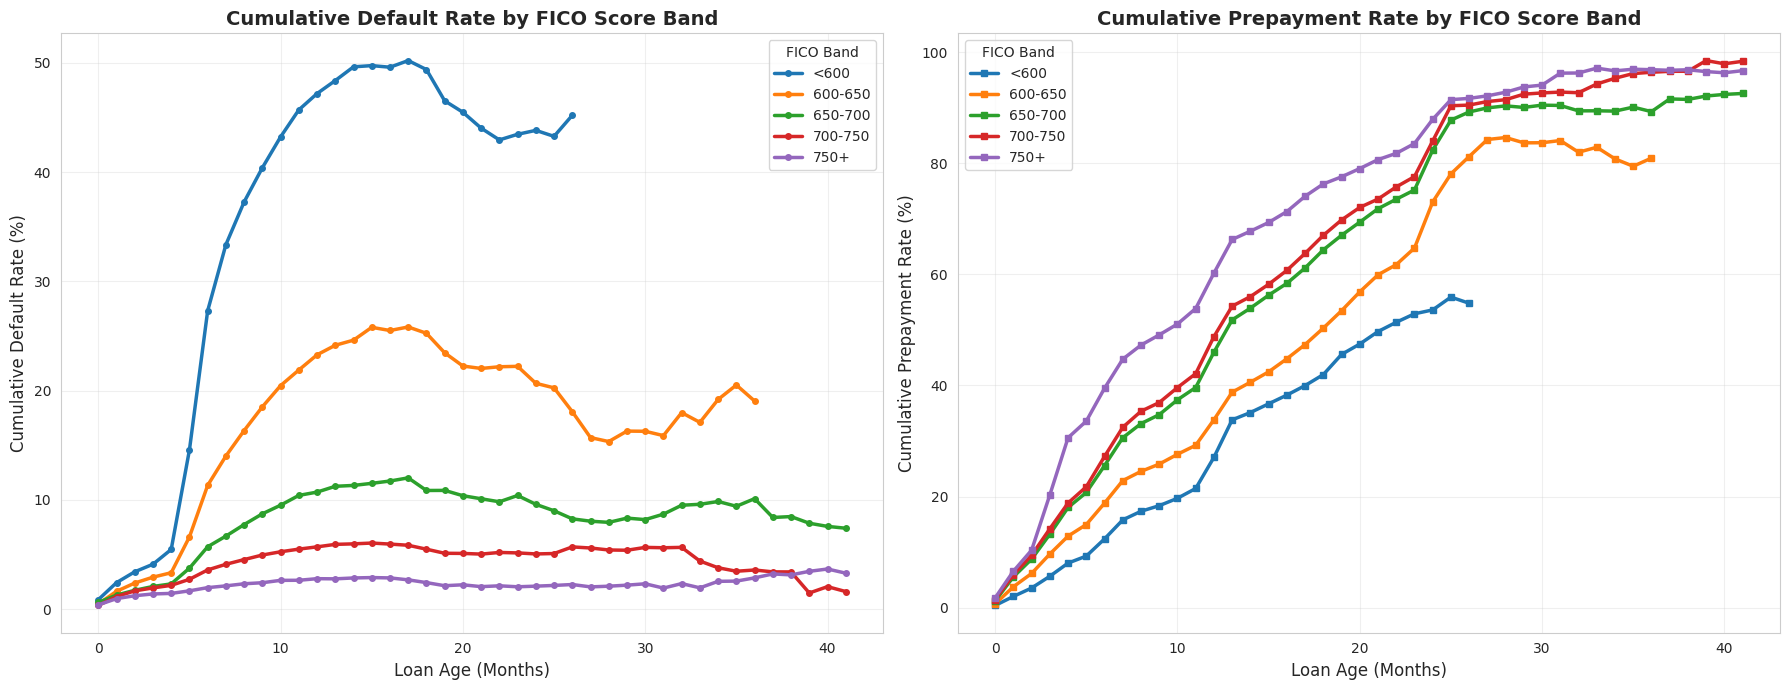

In [ ]:
# Plot cumulative default and prepayment by FICO band
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Cumulative default by FICO
for fico in fico_labels:
    data = fico_curves_filtered[fico_curves_filtered['fico_band'] == fico]
    axes[0].plot(data['loan_age_months'], data['cum_default_rate'],
                 marker='o', linewidth=2.5, markersize=4, label=fico)

axes[0].set_xlabel('Loan Age (Months)', fontsize=12)
axes[0].set_ylabel('Cumulative Default Rate (%)', fontsize=12)
axes[0].set_title('Cumulative Default Rate by FICO Score Band', fontsize=14, fontweight='bold')
axes[0].legend(title='FICO Band', fontsize=10)
axes[0].grid(alpha=0.3)

# Cumulative prepayment by FICO
for fico in fico_labels:
    data = fico_curves_filtered[fico_curves_filtered['fico_band'] == fico]
    axes[1].plot(data['loan_age_months'], data['cum_prepay_rate'],
                 marker='s', linewidth=2.5, markersize=4, label=fico)

axes[1].set_xlabel('Loan Age (Months)', fontsize=12)
axes[1].set_ylabel('Cumulative Prepayment Rate (%)', fontsize=12)
axes[1].set_title('Cumulative Prepayment Rate by FICO Score Band', fontsize=14, fontweight='bold')
axes[1].legend(title='FICO Band', fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 7.5. Cumulative Default by Vintage and Loan Term

Analyze how default rates vary by both vintage (origination period) and loan term.

## 8. Summary Statistics and Key Metrics

## 9. Export Key Datasets

In [ ]:
# Save key analytical datasets for further analysis
print("Exporting analytical datasets...")

# 1. Roll rate matrix
roll_rate_matrix.to_csv('roll_rate_matrix.csv')
print("✓ roll_rate_matrix.csv")

# 2. Cumulative default/prepay by age
cdr_by_age_filtered.to_csv('cumulative_rates_by_age.csv', index=False)
print("✓ cumulative_rates_by_age.csv")

# 3. Cumulative rates by vintage
vintage_curves_filtered.to_csv('cumulative_rates_by_vintage.csv', index=False)
print("✓ cumulative_rates_by_vintage.csv")

# 4. Cumulative rates by FICO
fico_curves_filtered.to_csv('cumulative_rates_by_fico.csv', index=False)
print("✓ cumulative_rates_by_fico.csv")

# 5. Loan-level analysis with all indicators
loan_analysis[['display_id', 'loan_status', 'defaulted', 'prepaid', 'fico_score', 'fico_band',
               'approved_amount', 'loan_term', 'program', 'vertical', 'disbursement_d']].to_csv(
    'loan_level_analysis.csv', index=False
)
print("✓ loan_level_analysis.csv")

print("\nAll datasets exported successfully!")

## Summary

This notebook has provided comprehensive data exploration including:

1. **Data Loading & Cleaning**: Loaded loan tape and performance data, cleaned formats, converted dates

2. **Loan Age Calculation**: Calculated loan age in months from disbursement date to each report date

3. **Delinquency Status**: Created delinquency buckets (Current, 1-30 DPD, 31-60 DPD, etc.) and severity indicators

4. **Historical Roll Rates**: Built transition matrix showing probability of moving from one delinquency state to another, including default and prepayment

5. **Cumulative Default Rates**: Analyzed cumulative default rates by:
   - Overall loan age
   - Vintage cohorts
   - FICO score bands

6. **Cumulative Prepayment Rates**: Analyzed cumulative prepayment rates by:
   - Overall loan age
   - Vintage cohorts
   - FICO score bands

7. **Key Insights**:
   - Default rates increase significantly with delinquency severity
   - Lower FICO scores correlate with higher default rates
   - Prepayment behavior varies by credit quality
   - Roll rates provide predictive power for default probability

All key datasets have been exported for further modeling and analysis.